In [191]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from a3_utils import draw_line
from PIL import Image
import os

1 b

In [21]:
def gauss(sigma):
    N = int(2* np.ceil(3*sigma) + 1)    #velikost kernela
    x = np.linspace(-(N-1)/2, (N-1)/2, N)    #N tock, N-1 je tm k mors 0 upostevat
    g = np.exp(-(x**2) / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi)) #gauss formula

    #return as a column vector
    g = g.reshape(1,N)

    return x, g


In [22]:
def gaussdx(sigma):
    N = int(2* np.ceil(3*sigma) + 1)
    x = np.linspace(-N/2, N/2, N)
    G = -np.exp(-x**2/(2*sigma**2)) * (1/(np.sqrt(2*np.pi)*sigma**3)) * x

    abs_sum = np.sum(np.abs(G))
    G = G/abs_sum

    #return as a column vector
    G = G.reshape(1,N)
    
    return G

1 c

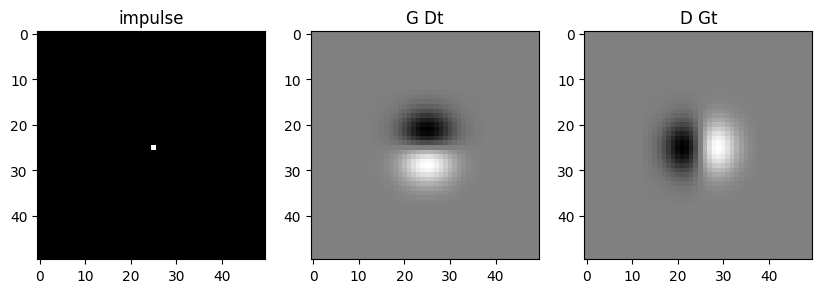

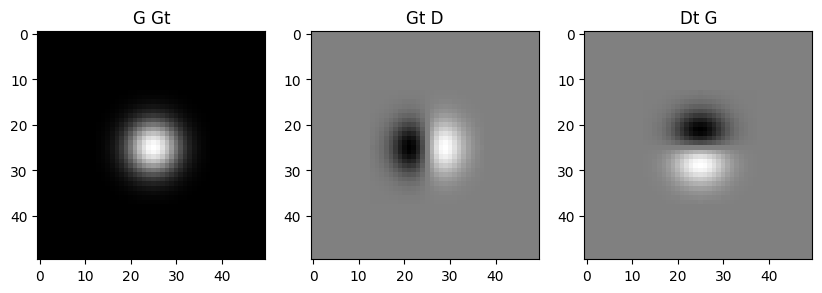

In [23]:
impulse = np.zeros((50,50))
impulse[25,25] = 1

#1d gaussian
sigma = 4
_,G = gauss(sigma)
Gt = G.T

#1d gaussian derivative
D = gaussdx(sigma)
Dt = D.T


ImG = cv2.filter2D(impulse,-1,G)
ImGGt = cv2.filter2D(ImG,-1,Gt)

#b
ImGDt = cv2.filter2D(ImG,-1,Dt)

#c
ImD = cv2.filter2D(impulse,-1,D)
ImDGt = cv2.filter2D(ImD,-1,Gt)

#d
ImGt = cv2.filter2D(impulse,-1,Gt)
ImGtD = cv2.filter2D(ImGt,-1,D)

#e
ImDt = cv2.filter2D(impulse,-1,Dt)
ImDtG = cv2.filter2D(ImDt,-1,G)

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(impulse, cmap='gray')
plt.title('impulse')
plt.subplot(1,3,2)
plt.imshow(ImGDt, cmap='gray')
plt.title('G Dt')
plt.subplot(1,3,3)
plt.imshow(ImDGt, cmap='gray')
plt.title('D Gt')
plt.show()

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(ImGGt, cmap='gray')
plt.title('G Gt')
plt.subplot(1,3,2)
plt.imshow(ImGtD, cmap='gray')
plt.title('Gt D')
plt.subplot(1,3,3)
plt.imshow(ImDtG, cmap='gray')
plt.title('Dt G')
plt.show()



1 d

In [24]:
def computePartialDerivatives(image, sigma):
    # compute partial derivatives
    _,G = gauss(sigma)
    D = gaussdx(sigma)

    Ix = cv2.filter2D(cv2.filter2D(image, -1, G.T), -1, D)
    Iy = cv2.filter2D(cv2.filter2D(image, -1, G), -1, D.T)

    return Ix, Iy

In [25]:
def computePartialSecondDerivatives(image, sigma):
    # compute partial derivatives
    _,G = gauss(sigma)
    D = gaussdx(sigma)

    Ix, Iy = computePartialDerivatives(image, sigma)

    Ixx = cv2.filter2D(cv2.filter2D(Ix, -1, G.T), -1, D)
    Iyy = cv2.filter2D(cv2.filter2D(Iy, -1, G), -1, D.T)
    Ixy = cv2.filter2D(cv2.filter2D(Ix, -1, G), -1, D.T)

    return Ixx, Iyy, Ixy

In [26]:
def gradient_magnitude(I,sigma):
    Ix, Iy = computePartialDerivatives(I, sigma)
    
    magnitude = np.sqrt(Ix**2 + Iy**2)
    angles = np.arctan2(Iy, Ix)

    return magnitude, angles

Text(0.5, 1.0, 'angles')

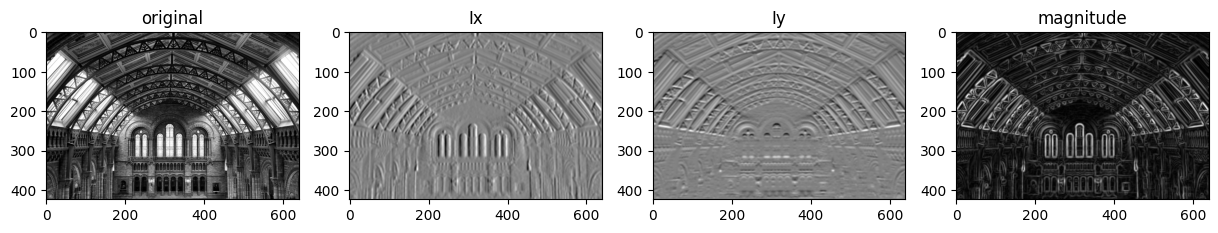

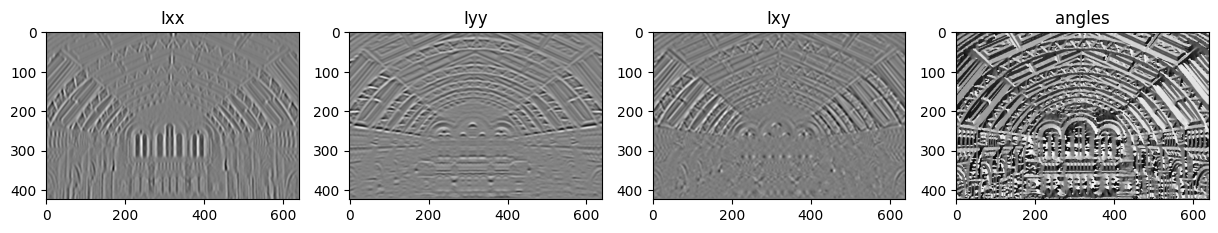

In [27]:
#read museum image
img = cv2.imread('images/museum.jpg', cv2.IMREAD_GRAYSCALE) / 255.0

#compute partial derivatives
Ix, Iy = computePartialDerivatives(img, 2)
Ixx, Iyy, Ixy = computePartialSecondDerivatives(img, 2)
mag,angl = gradient_magnitude(img,2)

plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(img, cmap='gray')
plt.title('original')
plt.subplot(1,4,2)
plt.imshow(Ix, cmap='gray')
plt.title('Ix')
plt.subplot(1,4,3)
plt.imshow(Iy, cmap='gray')
plt.title('Iy')
plt.subplot(1,4,4)
plt.imshow(mag, cmap='gray')
plt.title('magnitude')

plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(Ixx, cmap='gray')
plt.title('Ixx')
plt.subplot(1,4,2)
plt.imshow(Iyy, cmap='gray')
plt.title('Iyy')
plt.subplot(1,4,3)
plt.imshow(Ixy, cmap='gray')
plt.title('Ixy')
plt.subplot(1,4,4)
plt.imshow(angl, cmap='gray')
plt.title('angles')

1 e

In [189]:
def getHistogram(image):

    mag,angl = gradient_magnitude(image,2)  

    height, width = image.shape
    num_cells_y = height // 8
    num_cells_x = width // 8

    histograms = np.zeros((num_cells_y, num_cells_x, 8))

    for y in range(num_cells_y):
        for x in range(num_cells_x):
            cell_mag = mag[y * 8 : (y + 1) * 8, x * 8 : (x + 1) * 8]
            cell_angl = angl[y * 8 : (y + 1) * 8, x * 8 : (x + 1) * 8]

            cell_mag = cell_mag.flatten()
            cell_angl = cell_angl.flatten()

            #koti so od -pi do pi, zato dodam pi pa pol z 2pi d je [0,1]
            bin_indices = ((cell_angl + np.pi) / (2 * np.pi) * 8).astype(int)

            for i in range(8):
                histograms[y, x, i] = np.sum(cell_mag[bin_indices == i])

    feature_vector = histograms.flatten()

    return feature_vector

In [199]:
def compare_histograms(H1,H2,metric):
    if H1.shape != H2.shape:
        return None

    if metric == "l2":
        l2 = np.sqrt(np.sum(np.square(H1 - H2)))
        return np.floor(l2*1000)/1000
    elif metric == "Chi-square":
        chi = np.sum(np.square(H1 - H2) / (H1 + H2 + 1e-10)) * 0.5
        return np.floor(chi*1000)/1000
    elif metric == "intersection":
        inter = 1 - np.sum(np.minimum(H1, H2))
        return np.floor(inter*1000)/1000
    elif metric == "hellinger":
        hell = np.sqrt(np.sum(np.square(np.sqrt(H1) - np.sqrt(H2)))*0.5)
        return np.floor(hell*1000)/1000

In [190]:
imageName = "object_07_1.png"
image = cv2.imread('dataset/' + imageName, cv2.IMREAD_GRAYSCALE) / 255.0

feature_vector = getHistogram(image)

In [192]:
def getHistograms(directory):
    image_histograms = {}
    for filename in os.listdir(directory):
        if filename.endswith('.png'):
            filepath = os.path.join(directory, filename)
            image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE) / 255.0
            hist = getHistogram(image)
            image_histograms[filename] = hist.reshape(-1)

    return image_histograms

In [197]:
def getSimilarHist(image_dir,histograms,metric,directory):
    objects = []

    image =  cv2.imread('dataset/' + image_dir, cv2.IMREAD_GRAYSCALE) / 255.0
    image_histogram = getHistogram(image)

    for filename in os.listdir(directory):
        if image_dir == filename:
            continue
        if filename.endswith('.png'):
            distance = compare_histograms(image_histogram, histograms[filename], metric)
            objects.append((filename, distance))
    
    return objects

In [194]:
def printSimilar(objects, directory):
    objects.sort(key=lambda x: x[1])
    print(objects[:5])
    plt.figure(figsize=(20,3))
    for i in range(0, 5):
        plt.subplot(1,5,i+1)
        plt.imshow(np.asarray(Image.open(directory + "/"+objects[i][0]).convert('RGB')))
        plt.title(objects[i][0] + " " + str(objects[i][1]))
    plt.show()

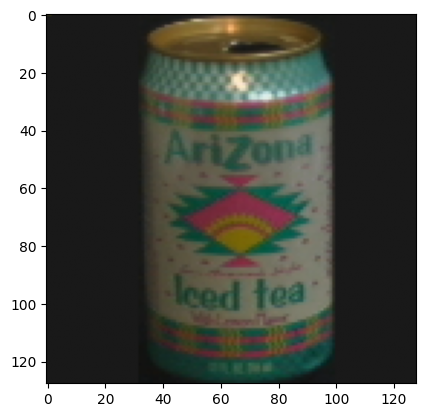

L2
[('object_07_4.png', 16.702), ('object_07_2.png', 16.78), ('object_07_3.png', 19.801), ('object_04_2.png', 31.556), ('object_28_3.png', 33.041)]


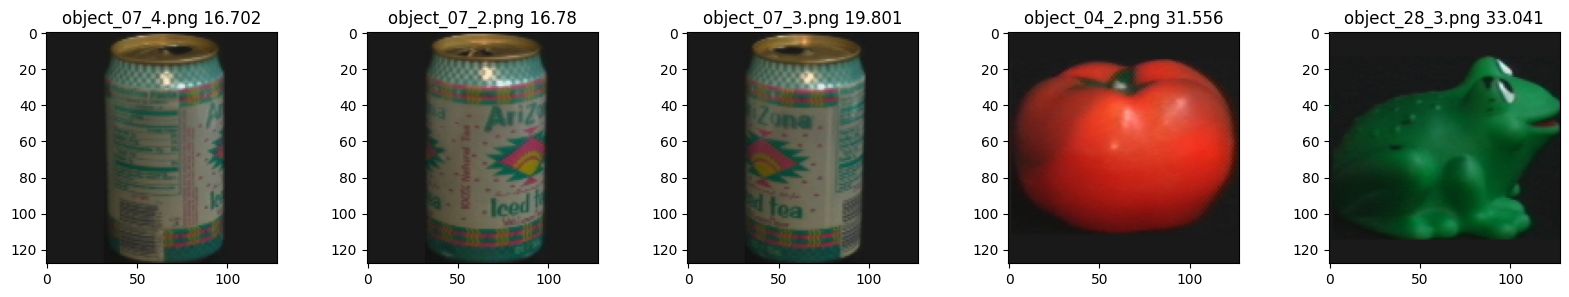

Chi-square
[('object_07_2.png', 89.241), ('object_07_4.png', 90.072), ('object_07_3.png', 112.528), ('object_24_1.png', 215.137), ('object_24_3.png', 225.835)]


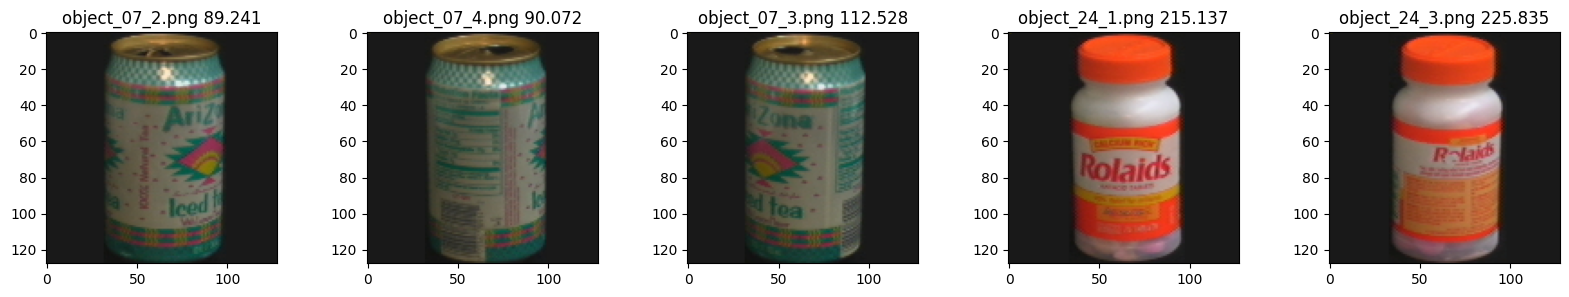

intersection
[('object_07_2.png', -242.659), ('object_07_4.png', -234.086), ('object_07_3.png', -215.085), ('object_22_1.png', -205.727), ('object_14_1.png', -168.18)]


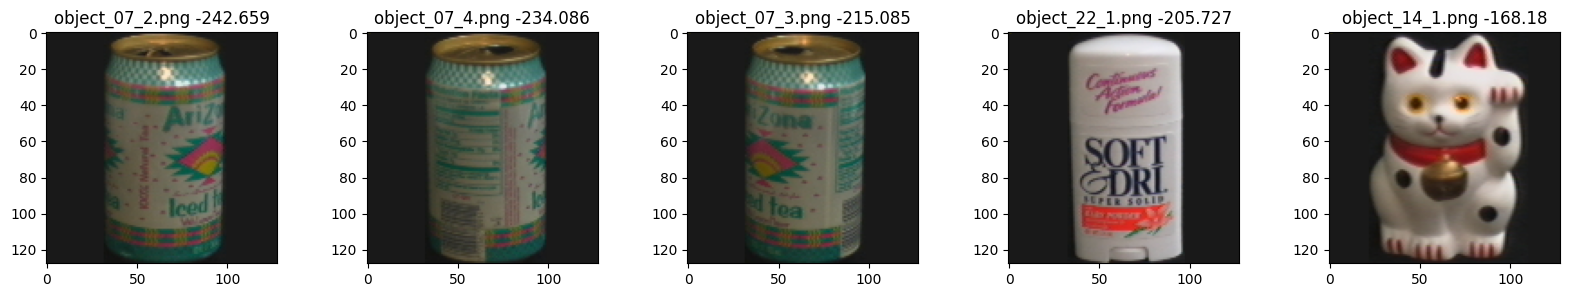

hellinger
[('object_07_2.png', 8.157), ('object_07_4.png', 8.266), ('object_07_3.png', 9.336), ('object_24_1.png', 13.261), ('object_24_3.png', 13.618)]


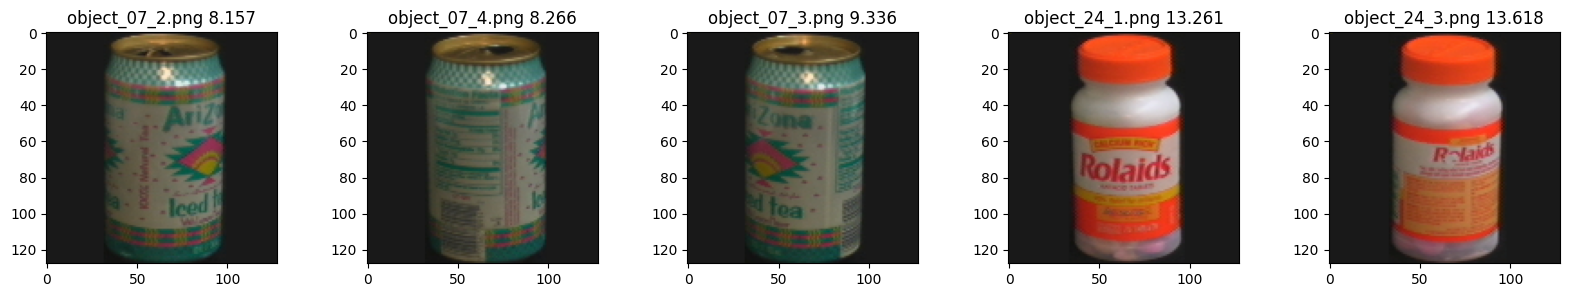

In [200]:
histograms = getHistograms("dataset")

imageName = "object_07_1.png"
image = np.asarray(Image.open("dataset/"+imageName).convert('RGB')).astype(np.float64) / 255
plt.imshow(image)
plt.show()

print("L2")
list1 = getSimilarHist(imageName,histograms,"l2","dataset")
printSimilar(list1, "dataset")

print("Chi-square")
list2 = getSimilarHist(imageName,histograms,"Chi-square","dataset")
printSimilar(list2, "dataset")

print("intersection")
list3 = getSimilarHist(imageName,histograms,"intersection","dataset")
printSimilar(list3, "dataset")

print("hellinger")
list4 = getSimilarHist(imageName,histograms,"hellinger","dataset")
printSimilar(list4, "dataset")


2 a

In [28]:
def findedges(I,sigma,theta):
    magnitude, _ = gradient_magnitude(I,sigma)

    Ie = np.zeros(I.shape)
    Ie[magnitude > theta] = 1

    return Ie

Text(0.5, 1.0, 'edges')

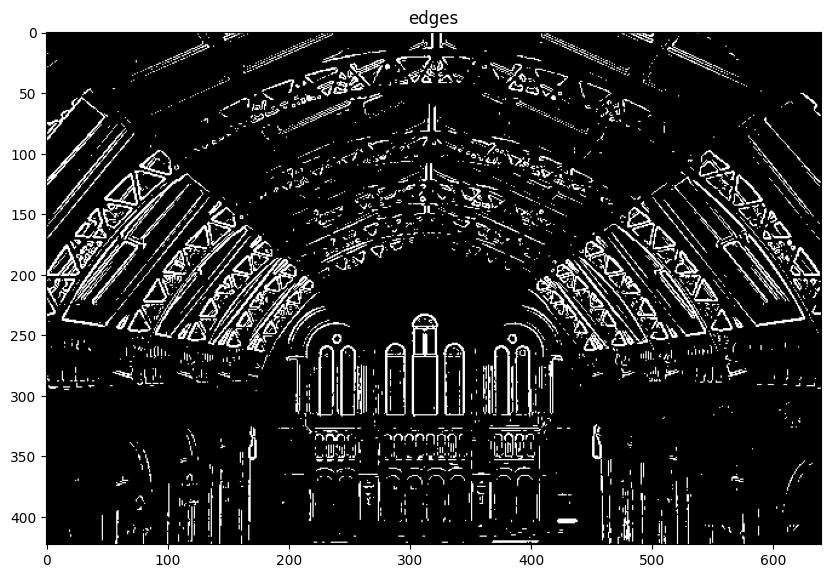

In [47]:
museum_edges = findedges(img, 0.8, 0.16)

plt.figure(figsize=(10,10))
plt.imshow(museum_edges, cmap='gray')
plt.title('edges')

2 b

In [170]:
def nonmaxsupp(img, sigma):
    magnitude, angles = gradient_magnitude(img, sigma)

    Ie = np.zeros(magnitude.shape)
    
    angle = angles * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(0,magnitude.shape[0]-1):
        for j in range(0,magnitude.shape[1]-1):
            q = 1
            r = 1
            
            #angle 0
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = magnitude[i, j+1]
                r = magnitude[i, j-1]
            #angle 45
            elif (22.5 <= angle[i,j] < 67.5):
                q = magnitude[i+1, j-1]
                r = magnitude[i-1, j+1]
            #angle 90
            elif (67.5 <= angle[i,j] < 112.5):
                q = magnitude[i+1, j]
                r = magnitude[i-1, j]
            #angle 135
            elif (112.5 <= angle[i,j] < 157.5):
                q = magnitude[i-1, j-1]
                r = magnitude[i+1, j+1]
                
            if (magnitude[i,j] >= q) and (magnitude[i,j] >= r):
                Ie[i,j] = magnitude[i,j]
            else:
                Ie[i,j] = 0

    return Ie

Text(0.5, 1.0, 'edges')

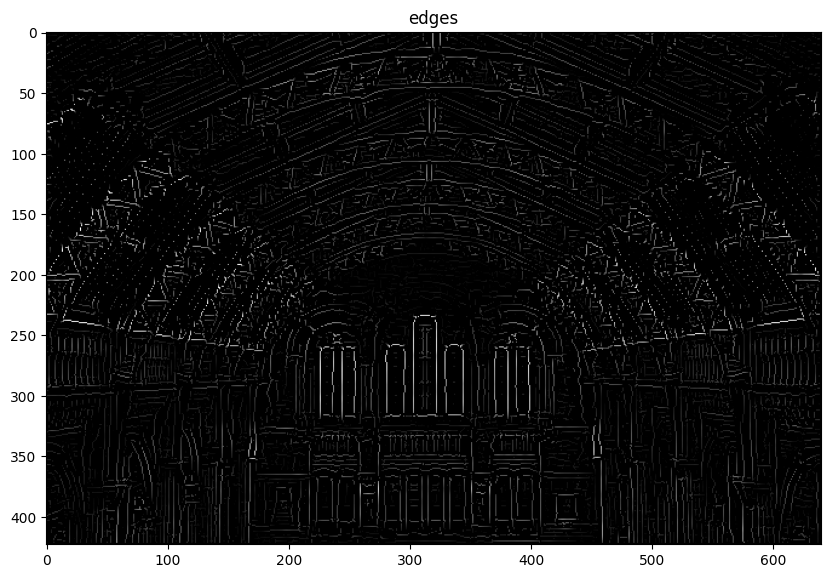

In [175]:
museum_edges = nonmaxsupp(img, 2)

plt.figure(figsize=(10,10))
plt.imshow(museum_edges, cmap='gray',)
plt.title('edges')

2 c

In [159]:
def hysteresis_threshold(edges, tlow, thigh):

    edges = (edges*255).astype(np.uint8)
    _, labels, stats, _ = cv2.connectedComponentsWithStats(edges)

    edges_above = (edges <= thigh)

    edges_below = (edges < tlow)

    result = np.zeros_like(edges, dtype=np.uint8)

    for i in range(1, stats.shape[0]): #cez vse komponente
        if stats[i, cv2.CC_STAT_AREA] > 2:  # mejhne vn vrze
            component_mask = (labels == i).astype(np.uint8) #komponenta

            # #ce je vsaj en pixel pod tlow, preskocimo
            component_below_tlow = np.sum(component_mask * edges_below) > 0
            if component_below_tlow:
                continue

            #ce je vsaj en pixel nad thigh dodamo crto
            component_above_thigh = np.sum(component_mask * edges_above) > 0

            if component_above_thigh:
                result += component_mask

    return result

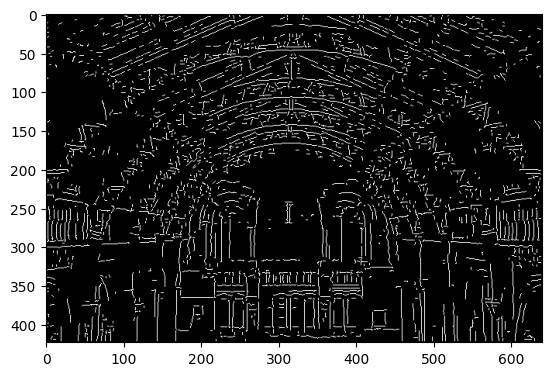

In [169]:
tlow = 0.04 * 255
thigh = 0.16 * 255

result = hysteresis_threshold(museum_edges, tlow, thigh)

plt.imshow(result, cmap='gray')


3 a

In [32]:
def hough_transform_accumulator(x, y, resolution_rho=300, resolution_theta=300):
    
    accumulator = np.zeros((resolution_rho, resolution_theta))

    for i in range(0,resolution_theta-1):
        theta = (i * np.pi / resolution_theta ) - np.pi / 2
        rho = x * np.cos(theta) + y * np.sin(theta)
        accumulator[int(resolution_rho/2+rho), i] += 1

    
    return accumulator


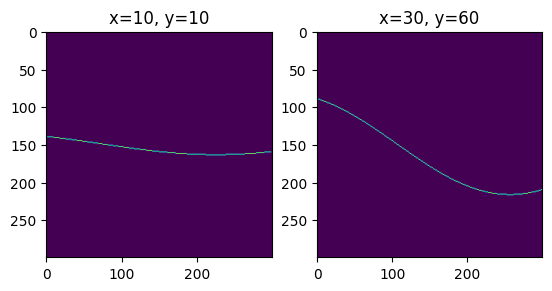

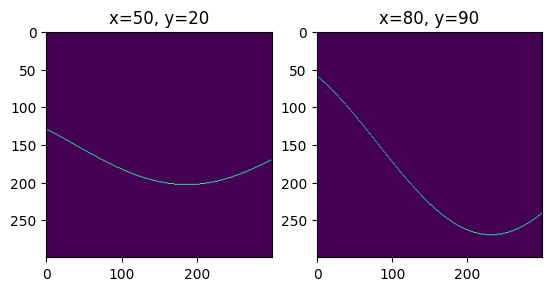

In [33]:
accumulator1 = hough_transform_accumulator(10,10)
accumulator2 = hough_transform_accumulator(30,60)
accumulator3 = hough_transform_accumulator(50,20)
accumulator4 = hough_transform_accumulator(80,90)

plt.subplot(1,2,1)
plt.imshow(accumulator1)
plt.title('x=10, y=10')

plt.subplot(1,2,2)
plt.imshow(accumulator2)
plt.title('x=30, y=60')

plt.show()

plt.subplot(1,2,1)
plt.imshow(accumulator3)
plt.title('x=50, y=20')

plt.subplot(1,2,2)
plt.imshow(accumulator4)
plt.title('x=80, y=90')

plt.show()

3 b

In [34]:
def hough_find_lines(img,resolution_rho=300, resolution_theta=300):
  thetas = np.deg2rad(np.arange(-90.0, 90.0, 180/resolution_theta))
  width, height = img.shape
  diag_len = int(np.ceil(np.sqrt(width * width + height * height)))  
  
  rhos = np.linspace(-diag_len, diag_len, resolution_rho) 
  
  cos_t = np.cos(thetas)
  sin_t = np.sin(thetas)

  accumulator = np.zeros((resolution_rho, resolution_theta), dtype=np.uint64)
  y_idxs, x_idxs = np.nonzero(img) 

  for i in range(len(x_idxs)):
    x = x_idxs[i]
    y = y_idxs[i]

    for t_idx in range(resolution_theta):
      rho = round(x * cos_t[t_idx] + y * sin_t[t_idx]) + diag_len
      rho = int(rho * resolution_rho / (2*diag_len))
      accumulator[rho, t_idx] += 1

  return accumulator, thetas, rhos

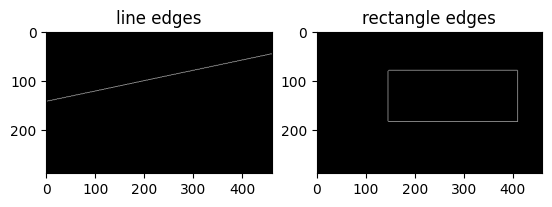

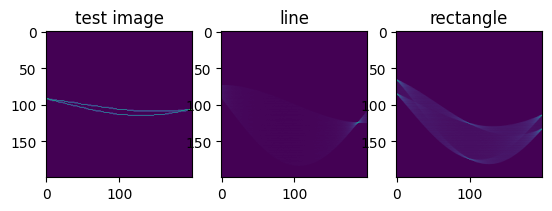

In [211]:
resolution_rho = 200
resolution_theta = 200

test_img = np.zeros((100,100)).astype(np.uint8)
test_img[10][10] = 255
test_img[10][20] = 255

accumulator, thetas1 , rhos1 = hough_find_lines(test_img,resolution_rho,resolution_theta)

#read images
line = cv2.imread('images/oneline.png', cv2.IMREAD_GRAYSCALE)
rectangle = cv2.imread('images/rectangle.png', cv2.IMREAD_GRAYSCALE)

#find edges
line_edges = cv2.Canny(line, 50,150)
rectangle_edges = cv2.Canny(rectangle, 50, 150)

plt.subplot(1,2,1)
plt.imshow(line_edges, cmap='gray')
plt.title('line edges')
plt.subplot(1,2,2)
plt.imshow(rectangle_edges, cmap='gray')
plt.title('rectangle edges')

plt.show()

#find lines
line_accumulator, thetas2,rhos2= hough_find_lines(line_edges,resolution_rho,resolution_theta)
rectangle_accumulator, thetas3,rhos3 = hough_find_lines(rectangle_edges,resolution_rho,resolution_theta)

plt.subplot(1,3,1)
plt.imshow(accumulator)
plt.title('test image')
plt.subplot(1,3,2)
plt.imshow(line_accumulator)
plt.title('line')
plt.subplot(1,3,3)
plt.imshow(rectangle_accumulator)
plt.title('rectangle')

plt.show()

3 c

In [36]:
def nonmaxima_suppression_box(I):

    #add padding
    I = np.pad(I, 1, 'constant', constant_values=0)

    for i in range(1,I.shape[0]-1):
        for j in range(1,I.shape[1]-1):
            if (I[i,j] > I[i-1,j-1]) and (I[i,j] > I[i-1,j]) and (I[i,j] > I[i-1,j+1]) and (I[i,j] > I[i,j-1]) and (I[i,j] > I[i,j+1]) and (I[i,j] > I[i+1,j-1]) and (I[i,j] > I[i+1,j]) and (I[i,j] > I[i+1,j+1]):
                I[i,j] = I[i,j]
            else:
                I[i,j] = 0
    
    #remove padding
    I = I[1:I.shape[0]-1, 1:I.shape[1]-1]

    return I

3 d

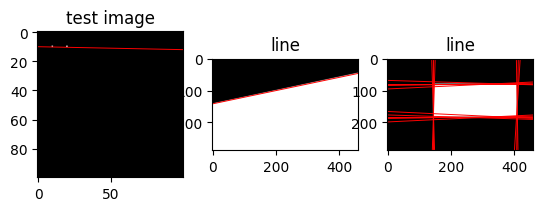

In [205]:
accumulator = nonmaxima_suppression_box(accumulator)

line_accumulator = nonmaxima_suppression_box(line_accumulator)
rectangle_accumulator = nonmaxima_suppression_box(rectangle_accumulator)

threshold = 1
y, x = np.where(accumulator > threshold)

plt.subplot(1,3,1)
plt.imshow(test_img, cmap='gray')
draw_line(rhos1[y][0],thetas1[x][0],test_img.shape[0],test_img.shape[1])
plt.title('test image')

idx = np.argmax(line_accumulator)
rho = rhos2[int(idx / line_accumulator.shape[1])]
theta = thetas2[idx % line_accumulator.shape[1]]

plt.subplot(1,3,2)
plt.imshow(line, cmap='gray')
draw_line(rho,theta,line.shape[0],line.shape[1])
plt.title('line')

#get top 4 lines
idx = np.argsort(rectangle_accumulator, axis=None)[::-1][:20]
y, x = np.unravel_index(idx, rectangle_accumulator.shape)
rhos = rhos2[y]
thetas = thetas2[x]

plt.subplot(1,3,3)
plt.imshow(rectangle, cmap='gray')
for i in range(0,15):
    draw_line(rhos[i],thetas[i],rectangle.shape[0],rectangle.shape[1])
plt.title('line')



plt.show()


§ e

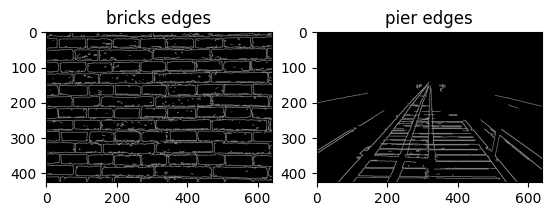

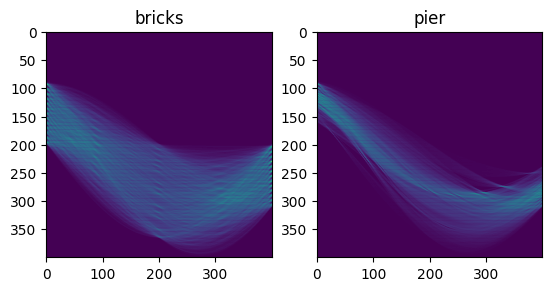

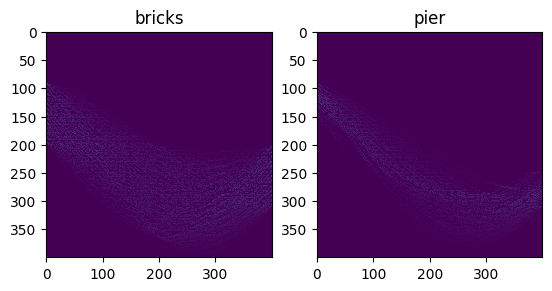

In [38]:
bricks = cv2.imread('images/bricks.jpg', cv2.IMREAD_GRAYSCALE)
pier = cv2.imread('images/pier.jpg', cv2.IMREAD_GRAYSCALE)

bricks_edges = cv2.Canny(bricks, 400, 250, 50)
pier_edges = cv2.Canny(pier, 500, 250, 100)

plt.subplot(1,2,1)
plt.imshow(bricks_edges, cmap='gray')
plt.title('bricks edges')
plt.subplot(1,2,2)
plt.imshow(pier_edges, cmap='gray')
plt.title('pier edges')

plt.show()

resolution_rho = 400
resolution_theta = 400

bricks_hough , thetas4, rhos4 = hough_find_lines(bricks_edges,resolution_rho,resolution_theta)
pier_hough , thetas5, rhos5 = hough_find_lines(pier_edges,resolution_rho,resolution_theta)

plt.subplot(1,2,1)
plt.imshow(bricks_hough)
plt.title('bricks')
plt.subplot(1,2,2)
plt.imshow(pier_hough)
plt.title('pier')

plt.show()

bricks_hough = nonmaxima_suppression_box(bricks_hough)
pier_hough = nonmaxima_suppression_box(pier_hough)

plt.subplot(1,2,1)
plt.imshow(bricks_hough)
plt.title('bricks')
plt.subplot(1,2,2)
plt.imshow(pier_hough)
plt.title('pier')

plt.show()



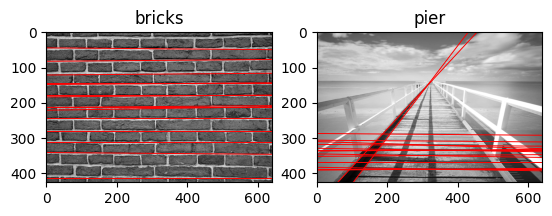

In [39]:
idx = np.argsort(bricks_hough, axis=None)[::-1][:20]
y, x = np.unravel_index(idx, bricks_hough.shape)
rhos = rhos4[y]
thetas = thetas4[x]

plt.subplot(1,2,1)
plt.imshow(bricks, cmap='gray')
for i in range(0,15):
    draw_line(rhos[i],thetas[i],bricks.shape[0],bricks.shape[1])
plt.title('bricks')

idx = np.argsort(pier_hough, axis=None)[::-1][:20]
y, x = np.unravel_index(idx, pier_hough.shape)
rhos = rhos5[y]
thetas = thetas5[x]

plt.subplot(1,2,2)
plt.imshow(pier, cmap='gray')
for i in range(0,15):
    draw_line(rhos[i],thetas[i],pier.shape[0],pier.shape[1])
plt.title('pier')

plt.show()

3 f

In [253]:
def hough_find_lines_angles(img,angles,resolution_rho=300, resolution_theta=300):
    thetas = np.deg2rad(np.arange(-90.0, 90.0, 180/resolution_theta))
    width, height = img.shape
    diag_len = int(np.ceil(np.sqrt(width * width + height * height)))  
    
    rhos = np.linspace(-diag_len, diag_len, resolution_rho) 
    
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)

    accumulator = np.zeros((resolution_rho, resolution_theta), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(img) 

    #angles so od -pi do pi sam rabmo od -pi/2 do pi/2
    angles[angles <= -np.pi/2] += np.pi
    angles[angles >= np.pi/2] -= np.pi

    angles = np.unique(angles)

    skip_thetas = []
    #if theta is not close to any of the angles
    for i in range(len(thetas)):
        if not any(np.isclose(thetas[i], angles)):
            skip_thetas.append(i)

    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(len(thetas)):

            if t_idx in skip_thetas:
                continue

            rho = round(x * cos_t[t_idx] + y * sin_t[t_idx]) + diag_len
            rho = int(rho * resolution_rho / (2*diag_len))
            accumulator[rho, t_idx] += 1

    

    return accumulator, thetas, rhos

Text(0.5, 1.0, 'rectangle')

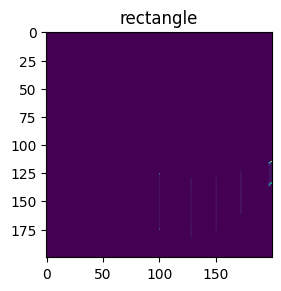

In [254]:
_,angles = gradient_magnitude(rectangle,2) 

rectangle_hough , thetas6, rhos6 = hough_find_lines_angles(rectangle_edges,angles,resolution_rho,resolution_theta)

plt.subplot(1,2,1)
plt.imshow(rectangle_hough)
plt.title('rectangle')


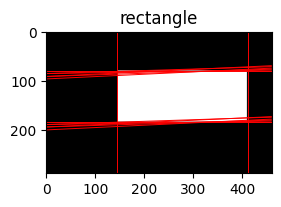

In [257]:
idx = np.argsort(rectangle_hough, axis=None)[::-1][:20]
y, x = np.unravel_index(idx, rectangle_hough.shape)
rhos = rhos6[y]
thetas = thetas6[x]

plt.subplot(1,2,2)
plt.imshow(rectangle, cmap='gray')
for i in range(0,14):
    draw_line(rhos[i],thetas[i],rectangle.shape[0],rectangle.shape[1])
plt.title('rectangle')

plt.show()

3 g

In [42]:
def hough_transform_circle(image, radius):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    edges = cv2.Canny(blurred, 50, 150)

    # plt.imshow(edges)
    # plt.show()

    hough_space = np.zeros_like(blurred)

    for y in range(edges.shape[0]):
        for x in range(edges.shape[1]):
            if edges[y, x] > 0: # za vsak pixel narise krog
                for theta in range(360):
                    a = int(x - radius * np.cos(np.radians(theta)))
                    b = int(y + radius * np.sin(np.radians(theta)))

                    if 0 <= a < edges.shape[1] and 0 <= b < edges.shape[0]:
                        hough_space[b, a] += 1

    plt.imshow(hough_space)
    plt.show()

    threshold = 100 
    circle_centers = np.where(hough_space > threshold)

    for i in range(len(circle_centers[0])):
        cv2.circle(image, (circle_centers[1][i], circle_centers[0][i]), radius, (0, 255, 0), 2)

    return image

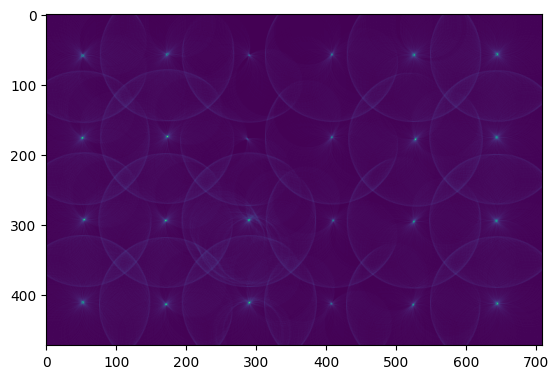

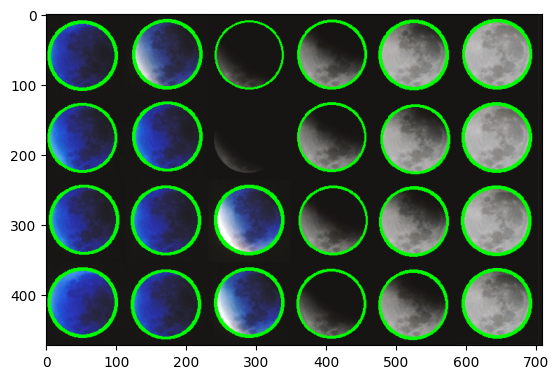

In [43]:
image = cv2.imread('images/eclipse.jpg')

radius_to_detect = 48

result_image = hough_transform_circle(image, radius_to_detect)

plt.imshow(image)
plt.imshow(result_image)


3 h